In [2]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 6.4MB/s 
     |████████████████████████████████| 9.5MB 20.8MB/s 
     |████████████████████████████████| 2.1MB 53.6MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error
import plotly.graph_objs as go

#from pylab import rcParams 

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

from fbprophet import Prophet

import warnings

In [2]:
def plotar_grafico(var_data, var_x, var_y, var_title, var_media_movel=""):
    plt.figure(figsize=(15,5))

    sns.lineplot(x=var_x, y=var_y, data=var_data[:50], palette="tab10", linewidth=1.5)

    if var_media_movel != "":
        sns.lineplot(x='Data', y= var_media_movel, data= var_data[:50])

    plt.title(var_title)
    plt.xticks(rotation= 30)
    plt.show()

In [3]:
def plotar_decompose(var_data,var_coluna, var_title, var_model='additive'):
    
    decomposicao =  seasonal_decompose(var_data[var_coluna], model=var_model)

    fig, (ax1,ax2,ax3, ax4) = plt.subplots(4,1, figsize=(15,10))

    decomposicao.observed.plot(ax=ax1)
    decomposicao.trend.plot(ax=ax2)
    decomposicao.seasonal.plot(ax=ax3)
    decomposicao.resid.plot(ax=ax4)

    ax1.set_ylabel('Observed')
    ax2.set_ylabel('trend')
    ax3.set_ylabel('seasonal')
    ax4.set_ylabel('resid')

    fig.axes[0].set_title(var_title)

In [4]:
url_file = 'https://raw.githubusercontent.com/mboliveira2006/analise_previsao_series_temporais/main/dados/A105613189_28_143_208.csv'

In [5]:
dados = pd.read_csv(url_file, encoding='ISO-8859-1', sep=';', skiprows=3, skipfooter=16, engine='python') 
dados.head()

,Ano Diagnóstico,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez,Total
0,2001,8088,6542,8095,7305,7656,6805,6987,8065,6697,7524,6874,6627,87265
1,2002,8013,7346,7961,8771,7784,6713,7746,8330,7654,8200,7532,6809,92859
2,2003,8115,7985,7474,7975,8024,7082,7949,7585,8136,8521,7624,7303,93773
3,2004,7574,6743,8574,8089,7763,7314,7825,8232,7901,8016,7753,7196,92980
4,2005,7432,6748,8441,7958,8019,7781,7282,8391,7690,7186,7587,7541,92056


In [6]:
dados = dados.drop("Total",axis=1)
dados = dados.drop(19,axis=0)

In [7]:
dados_time_series = dados.melt(id_vars="Ano Diagnóstico", value_name="Casos", var_name="Mes")

dados_time_series['Data'] = dados_time_series["Ano Diagnóstico"] + "-" + dados_time_series["Mes"]


In [8]:
dados_time_series.head()

,Ano Diagnóstico,Mes,Casos,Data
0,2001,Jan,8088,2001-Jan
1,2002,Jan,8013,2002-Jan
2,2003,Jan,8115,2003-Jan
3,2004,Jan,7574,2004-Jan
4,2005,Jan,7432,2005-Jan


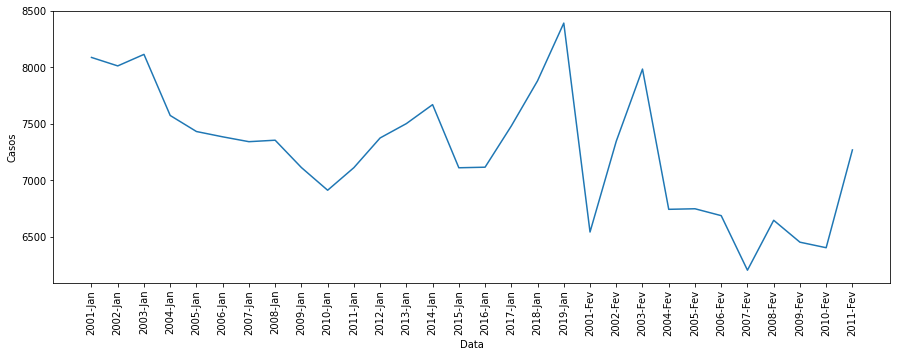

In [9]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Data', y='Casos', data=dados_time_series[:30])

plt.xticks(rotation= 90)
plt.show()

In [10]:
dados_time_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Ano Diagnóstico  228 non-null    object
 1   Mes              228 non-null    object
 2   Casos            228 non-null    int64 
 3   Data             228 non-null    object
dtypes: int64(1), object(3)
memory usage: 7.2+ KB


In [11]:
#dados_time_series['data_new'] = dados_time_series['data'].map(str) + '-01'

In [12]:
meses_dict = {'Jan':'Jan',
                'Fev':'Feb',
                'Mar':'Mar',
                'Abr':'Apr',
                'Mai':'May',
                'Jun':'Jun',
                'Jul':'Jul',
                'Ago':'Aug',
                'Set':'Sep',
                'Out':'Oct',
                'Nov':'Nov',
                'Dez':'Dec'}

In [13]:
meses_dict_number = {'Jan':1,
                'Feb':2,
                'Mar':3,
                'Apr':4,
                'May':5,
                'Jun':6,
                'Jul':7,
                'Aug':8,
                'Sep':9,
                'Oct':10,
                'Nov':11,
                'Dec':12}

In [14]:
dados_time_series['Mes'] = dados_time_series['Mes'].map(meses_dict)

In [15]:
dados_time_series.sample(5)

,Ano Diagnóstico,Mes,Casos,Data
150,2018,Aug,8934,2018-Ago
164,2013,Sep,7377,2013-Set
227,2019,Dec,7220,2019-Dez
17,2018,Jan,7881,2018-Jan
126,2013,Jul,7379,2013-Jul


In [16]:
dados_time_series['Data'] = dados_time_series["Ano Diagnóstico"] + "-" + dados_time_series["Mes"]

In [18]:
dados_time_series['Data'] = pd.to_datetime(dados_time_series['Data'])

In [17]:
#dados_time_series['Mes'] = dados_time_series['Data'].map(dados_time_series['Data'].dt.month)

In [19]:
dados_time_series['Mes'] = dados_time_series['Mes'].map(meses_dict_number)


In [20]:
dados_time_series = dados_time_series[['Data','Casos','Mes']]

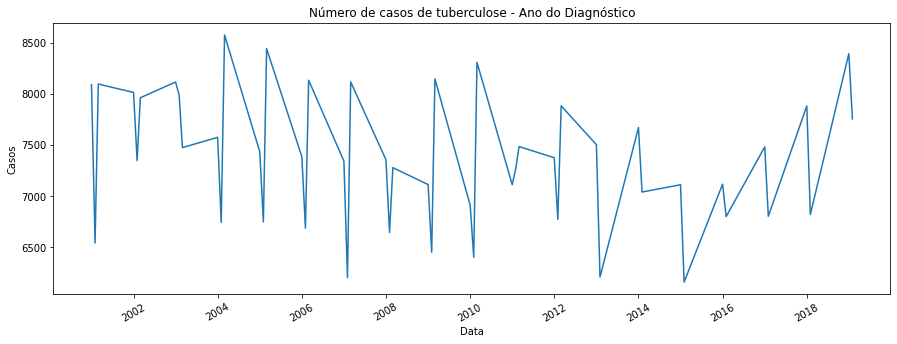

In [21]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico')

In [22]:
#ordenar o dataset pela data
dados_time_series =  dados_time_series.sort_values(by=['Data'])

dados_time_series = dados_time_series.reset_index(drop= True)

In [23]:
dados_time_series.head()

,Data,Casos,Mes
0,2001-01-01,8088,1
1,2001-02-01,6542,2
2,2001-03-01,8095,3
3,2001-04-01,7305,4
4,2001-05-01,7656,5


In [24]:
dados_time_series['MM_3'] = dados_time_series['Casos'].rolling(3).mean()

In [25]:
dados_time_series['MM_6'] = dados_time_series['Casos'].rolling(6).mean()

In [26]:
dados_time_series['MM_3c'] = dados_time_series['Casos'].rolling(3, center= True).mean()

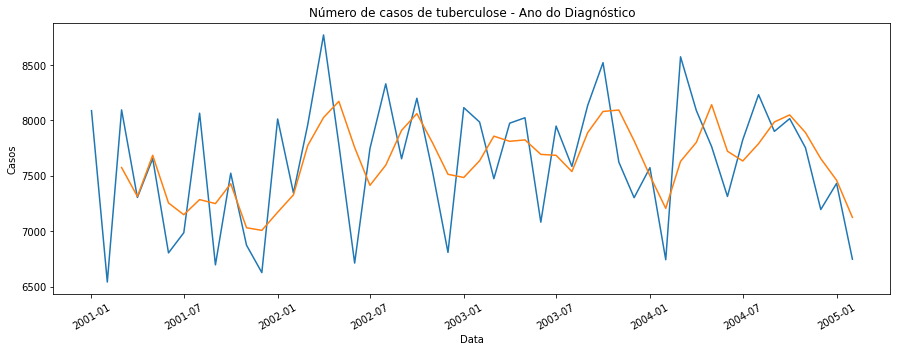

In [27]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico','MM_3')

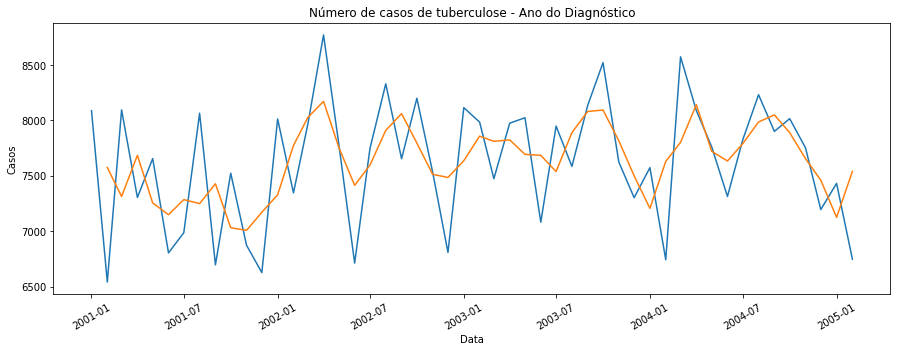

In [28]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico','MM_3c')

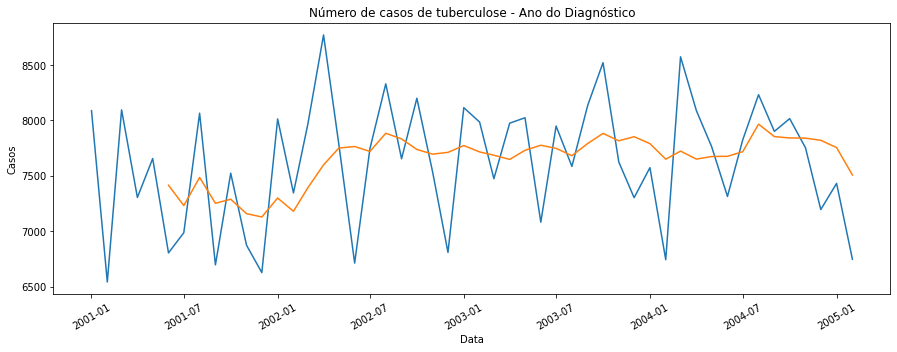

In [29]:
plotar_grafico(dados_time_series, 'Data', 'Casos', 'Número de casos de tuberculose - Ano do Diagnóstico','MM_6')

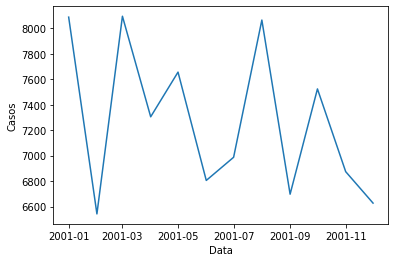

In [30]:
sns.lineplot(x='Data', y='Casos', data=dados_time_series[:12])

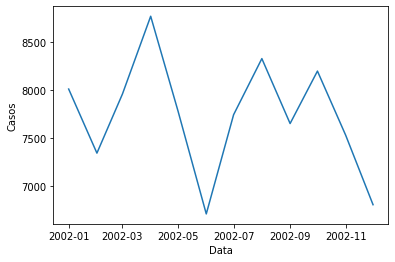

In [31]:
sns.lineplot(x='Data', y='Casos', data=dados_time_series[12:24])

In [32]:
dados_time_series['Ano'] = dados_time_series['Data'].dt.year
dados_time_series['Mes'] = dados_time_series['Data'].dt.month


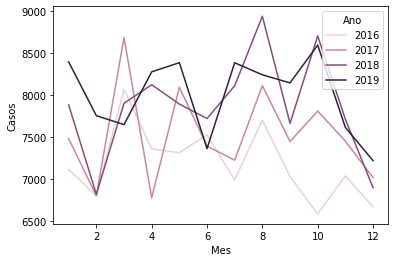

In [33]:
sns.lineplot(x='Mes', y='Casos', data=dados_time_series.query("Ano in[2019,2018,2017,2016]"), hue='Ano')

In [34]:
dados_time_series = dados_time_series.set_index('Data')

In [35]:
dados_time_series

,Casos,Mes,MM_3,MM_6,MM_3c,Ano
Data,,,,,,
2001-01-01,8088,1,NaN,NaN,NaN,2001
2001-02-01,6542,2,NaN,NaN,7575.000000,2001
2001-03-01,8095,3,7575.000000,NaN,7314.000000,2001
2001-04-01,7305,4,7314.000000,NaN,7685.333333,2001
2001-05-01,7656,5,7685.333333,NaN,7255.333333,2001
...,...,...,...,...,...,...
2019-08-01,8239,8,7994.666667,8048.166667,8254.666667,2019
2019-09-01,8143,9,8254.666667,8130.666667,8324.666667,2019
2019-10-01,8592,10,8324.666667,8183.666667,8116.666667,2019


In [37]:
decomposicao =  seasonal_decompose(dados_time_series['Casos'])

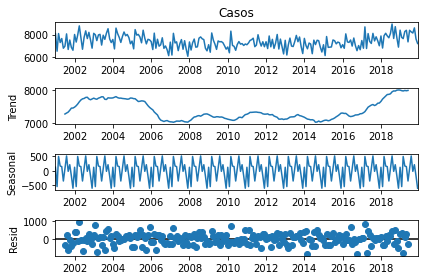

In [38]:
decomposicao.plot();


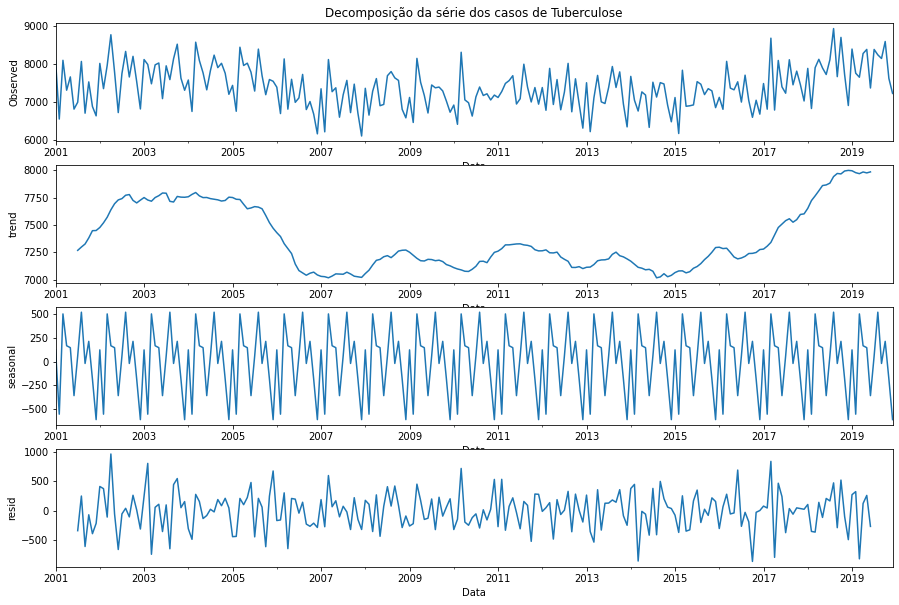

In [39]:
plotar_decompose(dados_time_series,'Casos','Decomposição da série dos casos de Tuberculose')

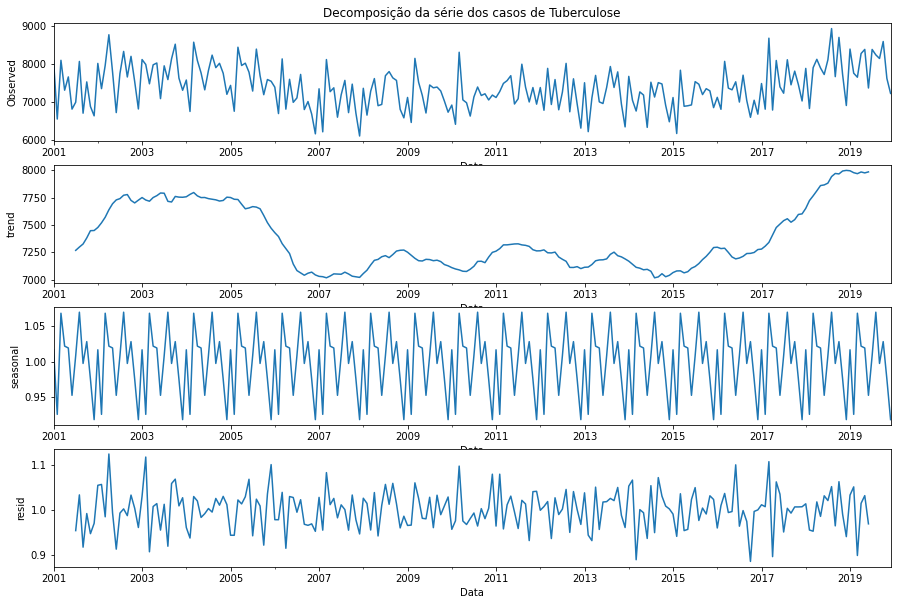

In [40]:
plotar_decompose(dados_time_series,'Casos', 'Decomposição da série dos casos de Tuberculose', 'multiplicative')

In [41]:
url_passageiros = 'https://raw.githubusercontent.com/mboliveira2006/analise_previsao_series_temporais/main/dados/AirPassengers.csv'
dados_passengers = pd.read_csv(url_passageiros)
dados_passengers['Month'] =  pd.to_datetime(dados_passengers['Month'])
dados_passengers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


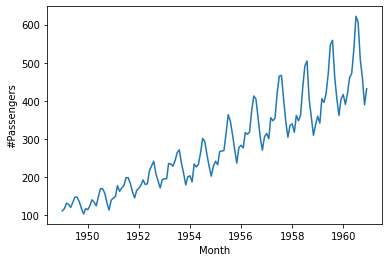

In [42]:
sns.lineplot(x ='Month', y ='#Passengers', data = dados_passengers)

In [43]:
dados_passengers

,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121
...,...,...
139,1960-08-01,606
140,1960-09-01,508
141,1960-10-01,461
142,1960-11-01,390


In [44]:
dados_passengers = dados_passengers.set_index('Month')


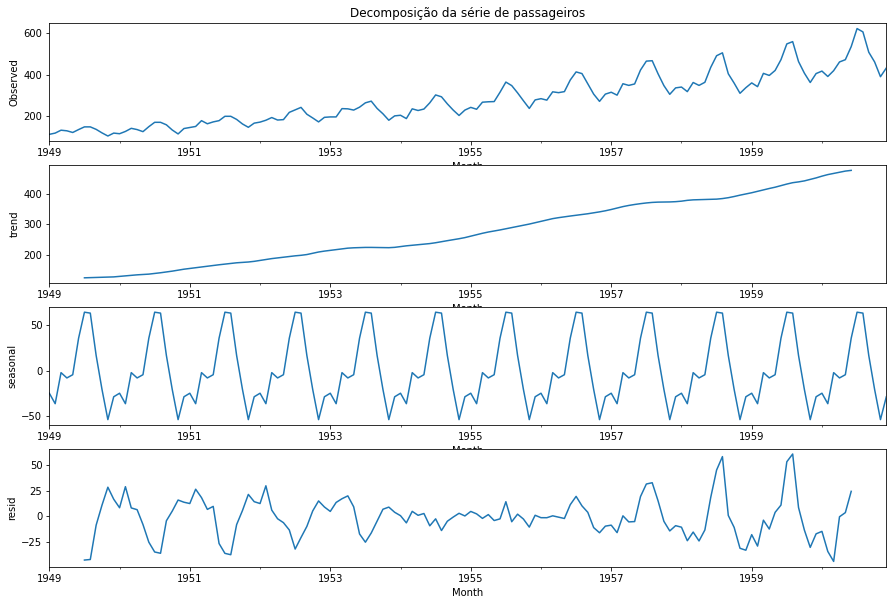

In [45]:
decomposicao_p =  seasonal_decompose(dados_passengers['#Passengers'])
#decomposicao.plot();

plotar_decompose(dados_passengers,'#Passengers', 'Decomposição da série de passageiros')

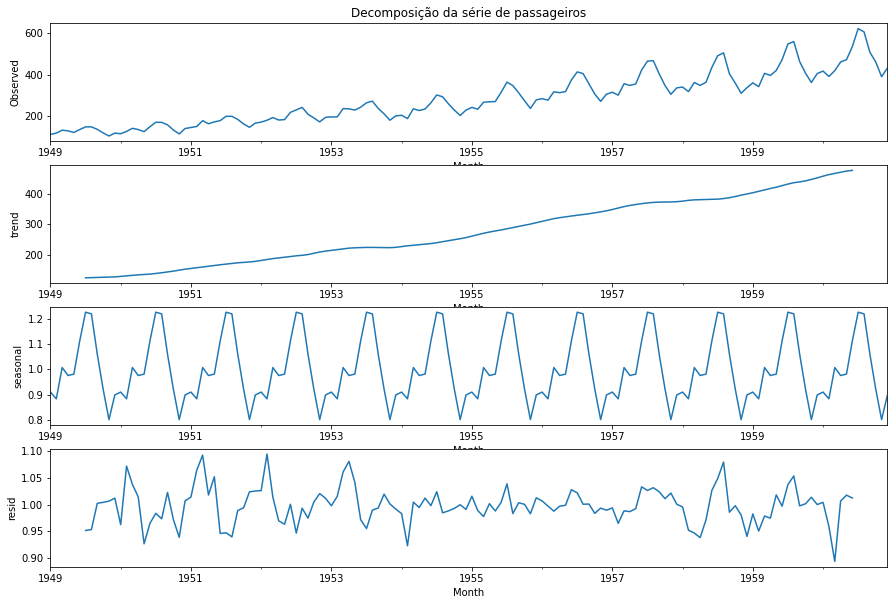

In [46]:
decomposicao_p =  seasonal_decompose(dados_passengers['#Passengers'], model='multiplicative')
#decomposicao.plot(2);


plotar_decompose(dados_passengers,'#Passengers', 'Decomposição da série de passageiros', 'multiplicative')

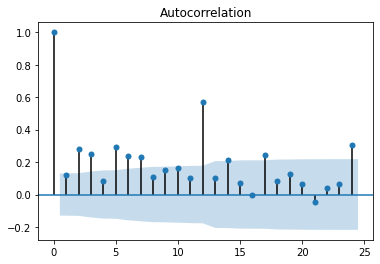

In [47]:
plot_acf(dados_time_series['Casos']);

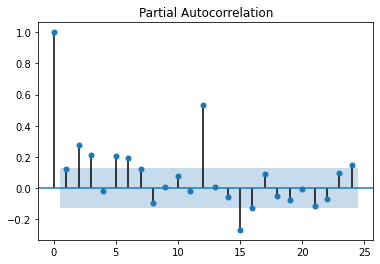

In [48]:
plot_pacf(dados_time_series['Casos']);

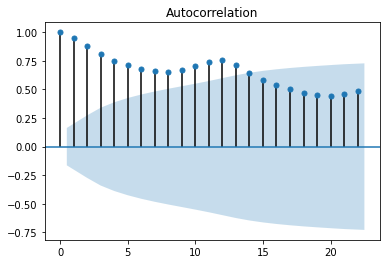

In [49]:
plot_acf(dados_passengers['#Passengers']);


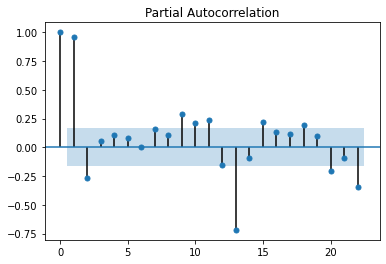

In [50]:
plot_pacf(dados_passengers['#Passengers']);

In [51]:
dados_passengers.reset_index(inplace=True)
dados_passengers.rename({'Month':'Data', '#Passengers':'Passageiros'}, axis=1, inplace=True)

In [52]:
dados_passengers['Mes'] = dados_passengers['Data'].dt.month
dados_passengers['Ano'] = dados_passengers['Data'].dt.year

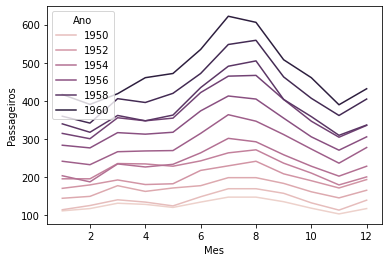

In [53]:
sns.lineplot(x='Mes', y='Passageiros', data= dados_passengers, hue='Ano')

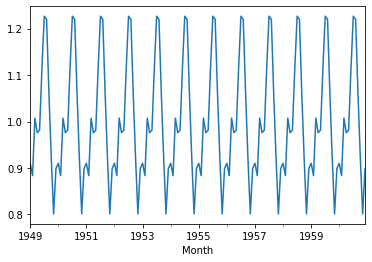

In [54]:
decomposicao_p.seasonal.plot()

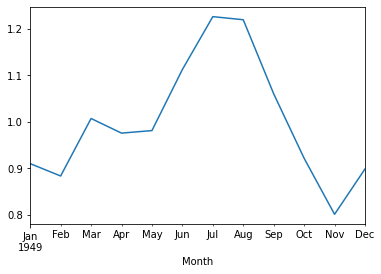

In [55]:
decomposicao_p.seasonal[:12].plot()

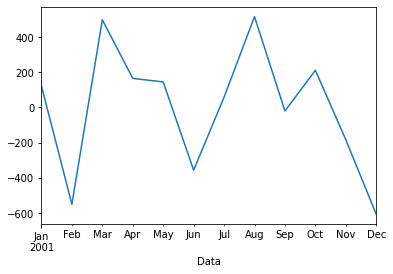

In [56]:
decomposicao.seasonal[:12].plot()

In [57]:
modelo_arima = ARIMA(dados_time_series['Casos'].values.astype('float32'), order=[0,0,0])
modelo_arima_treinado = modelo_arima.fit()

In [58]:
modelo_arima_treinado

In [59]:
modelo_arima_treinado.forecast(12)[0]

7389.285621375987

In [60]:
dados_treino = dados_time_series.query("Ano != 2019")
dados_teste = dados_time_series.query('Ano == 2019')

In [61]:
modelo_arima = ARIMA(dados_treino['Casos'].values.astype('float32'), order=[12,1,2])#Autoregressivo order=[1,0,0], média mvel   ordem 1 order=[0,0,1]
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



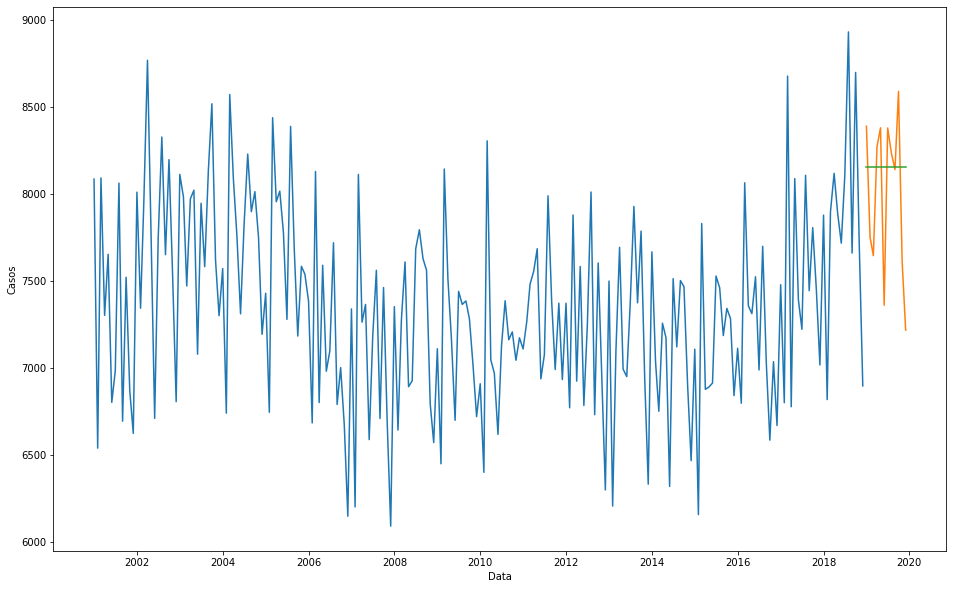

In [62]:
dados_teste['Previsao'] = previsao
plt.figure(figsize=(16,10))
sns.lineplot(x='Data', y='Casos', data= dados_treino)
sns.lineplot(x='Data', y='Casos', data= dados_teste)
sns.lineplot(x='Data', y='Previsao', data= dados_teste)


In [64]:
dados_treino_passageiros = dados_passengers.query("Ano != 1960")
dados_teste_passageiros = dados_passengers.query('Ano == 1960')

In [65]:
modelo_arima = ARIMA(dados_treino_passageiros['Passageiros'].values.astype('float32'), order=[2,1,2])#Autoregressivo order=[1,0,0], média mvel   ordem 1 order=[0,0,1]
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



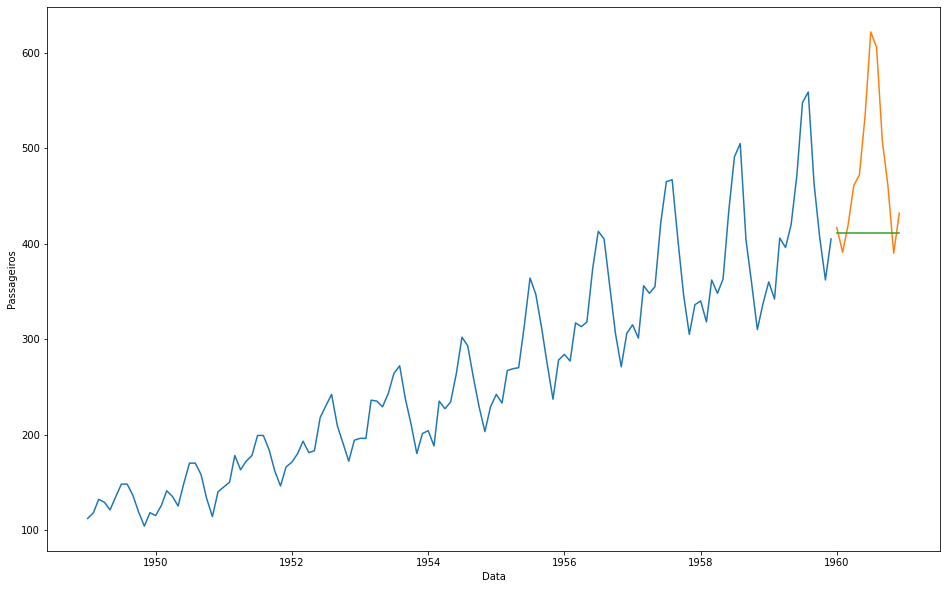

In [66]:
dados_teste_passageiros['Previsao'] = previsao
plt.figure(figsize=(16,10))
sns.lineplot(x='Data', y='Passageiros', data= dados_treino_passageiros)
sns.lineplot(x='Data', y='Passageiros', data= dados_teste_passageiros)
sns.lineplot(x='Data', y='Previsao', data= dados_teste_passageiros)

In [68]:
dados_treino

,Casos,Mes,MM_3,MM_6,MM_3c,Ano
Data,,,,,,
2001-01-01,8088,1,NaN,NaN,NaN,2001
2001-02-01,6542,2,NaN,NaN,7575.000000,2001
2001-03-01,8095,3,7575.000000,NaN,7314.000000,2001
2001-04-01,7305,4,7314.000000,NaN,7685.333333,2001
2001-05-01,7656,5,7685.333333,NaN,7255.333333,2001
...,...,...,...,...,...,...
2018-08-01,8934,8,8254.333333,8112.833333,8235.333333,2018
2018-09-01,7663,9,8235.333333,8073.166667,8432.666667,2018
2018-10-01,8701,10,8432.666667,8169.833333,8025.000000,2018


In [67]:
modelo_autoarima = auto_arima(dados_treino['Casos'].values,error_action='ignore'
                          , trace=True, seasonal=True, m=12 , ma)

SyntaxError: ignored

In [69]:
modelo_autoarima

NameError: ignored

In [ ]:
modelo_autoarima.predict(12)

In [ ]:
previsao_autoarima = modelo_autoarima.predict(12)

dados_teste['Previsao_autoarima'] = previsao_autoarima

plt.figure(figsize=(16,10))
#sns.lineplot(x='Data', y='Casos', data= dados_treino)
sns.lineplot(x='Data', y='Casos', data= dados_teste)
sns.lineplot(x='Data', y='Previsao_autoarima', data= dados_teste)
sns.lineplot(x='Data', y='Previsao', data= dados_teste)

In [ ]:
resultado_autoarima = mean_squared_error(dados_teste['Casos'], dados_teste['Previsao_autoarima'])
resultado_arima = mean_squared_error(dados_teste['Casos'], dados_teste['Previsao'])
print(f"Autoarima = {resultado_autoarima}")
print(f"Arima = {resultado_arima}")

##Previsão usando o Facebook Prophet

In [ ]:
dados_treino_passageiros_profeta = dados_treino_passageiros[['Data','Passageiros']].rename({'Data':'ds', 'Passageiros':'y'}, axis=1)

In [ ]:
modelo_profeta = Prophet(seasonality_mode='multiplicative')
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_passageiros_profeta[['ds','y']])

In [ ]:
#Criar na linha temporal do modelo o futuro
futuro = modelo_profeta_treinado.make_future_dataframe(periods=12,freq='M')
futuro


In [ ]:
#fazer a previsão
resultado_profeta = modelo_profeta_treinado.predict(futuro)


In [ ]:
resultado_profeta

In [ ]:
modelo_profeta_treinado.plot(resultado_profeta);

Dados Tuberculose

In [ ]:
dados_treino.reset_index(inplace=True)

In [ ]:
dados_treino_profeta = dados_treino[['Data','Casos']].rename({'Data':'ds', 'Casos':'y'}, axis=1)

In [ ]:
modelo_profeta = Prophet(seasonality_mode='multiplicative')#seasonality_mode='multiplicative'
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_profeta[['ds','y']])

In [ ]:
#Criar na linha temporal do modelo o futuro
futuro = modelo_profeta_treinado.make_future_dataframe(periods=12,freq='M')
resultado_profeta = modelo_profeta_treinado.predict(futuro)

In [ ]:
modelo_profeta_treinado.plot(resultado_profeta);

In [ ]:
modelo_profeta_treinado.plot_components(resultado_profeta);

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dados_teste.index, y=dados_teste['Casos'], name='Teste',))
fig.add_trace(go.Scatter(x=dados_treino_profeta['ds'], y=dados_treino_profeta['y'], name='Actual',))
fig.add_trace(go.Scatter(x=resultado_profeta['ds'], y=resultado_profeta['yhat'], name='Predicted',))
fig.show()

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=dados_treino_profeta['ds'], y=dados_treino_profeta['y'], name='Actual',))
fig.add_trace(go.Scatter(x=dados_teste.index, y=dados_teste['Casos'], name='Teste',))
fig.add_trace(go.Scatter(x=resultado_profeta['ds'], y=resultado_profeta['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=resultado_profeta['ds'], y=resultado_profeta['trend'], name='Trend',))

fig.show()

In [100]:
url_doleta = 'https://raw.githubusercontent.com/mboliveira2006/analise_previsao_series_temporais/main/dados/doleta_diario.csv'
#url_doleta = 'https://raw.githubusercontent.com/mboliveira2006/analise_previsao_series_temporais/main/dados/doleta_mensal.csv'

In [219]:
dados_dolar = pd.read_csv(url_doleta, sep=';', decimal=',')

In [197]:
dados_dolar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 801 entries, 3 to 4255
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Data                            801 non-null    object 
 1   Abertura                        801 non-null    float64
 2   Máxima                          801 non-null    float64
 3   Mínima                          801 non-null    float64
 4   Fechamento                      801 non-null    float64
 5   Média Móvel A [200]             801 non-null    float64
 6   Média Móvel A [50]              801 non-null    float64
 7   Média Móvel A [200].1           801 non-null    float64
 8   Média Móvel A [20]              801 non-null    float64
 9   Detector de Topos e Fundos [2]  801 non-null    float64
 10  VWAP D                          801 non-null    float64
dtypes: float64(10), object(1)
memory usage: 75.1+ KB


In [220]:
dados_dolar.isna().sum().sum()

4089

In [221]:
dados_dolar.dropna(inplace=True)

In [224]:
dados_dolar['Data'] = pd.to_datetime(dados_dolar['Data'], format='%d/%m/%Y')
dados_dolar.sort_values('Data', inplace=True)
dados_dolar.reset_index(drop=True, inplace=True)

In [225]:
dados_dolar

,Data,Abertura,Máxima,Mínima,Fechamento,Média Móvel A [200],Média Móvel A [50],Média Móvel A [200].1,Média Móvel A [20],Detector de Topos e Fundos [2],VWAP D
0,2003-10-31,3071.73,3103.65,3057.90,3088.76,3637.91,3181.02,3637.91,3096.86,3057.90,3080.51
1,2003-11-17,3160.04,3180.26,3134.51,3136.64,3568.93,3138.33,3568.93,3099.67,3180.26,3152.86
2,2003-11-24,3118.55,3130.25,3102.59,3114.29,3535.79,3130.59,3535.79,3107.46,3102.59,3116.42
3,2003-11-27,3138.76,3148.34,3124.93,3132.38,3515.45,3125.99,3515.45,3115.70,3148.34,3136.10
4,2003-12-02,3107.14,3117.66,3102.10,3117.13,3494.80,3121.12,3494.80,3121.92,3102.10,3111.01
...,...,...,...,...,...,...,...,...,...,...,...
796,2020-12-14,5040.00,5131.00,5011.00,5119.50,5345.89,5449.54,5345.89,5244.00,5011.00,5081.80
797,2020-12-28,5175.00,5311.50,5163.50,5239.50,5367.52,5374.55,5367.52,5153.32,5311.50,5249.74
798,2021-01-04,5137.50,5302.00,5121.50,5302.00,5373.78,5351.23,5373.78,5144.55,5121.50,5204.11
799,2021-01-11,5470.00,5520.00,5454.00,5491.00,5382.11,5328.85,5382.11,5204.57,5520.00,5495.86


In [226]:
dolar_time_series = dados_dolar[['Data','Fechamento']]


In [227]:
dolar_time_series.set_index('Data', inplace=True)

In [228]:
dolar_time_series.head(3)

,Fechamento
Data,
2003-10-31,3088.76
2003-11-17,3136.64
2003-11-24,3114.29


In [229]:
decomposicao =  seasonal_decompose(dolar_time_series['Fechamento'])
decomposicao.plot();

ValueError: ignored

In [170]:
dados_time_series['Fechamento'] = dolar_time_series['Fechamento']

In [122]:
decomposicao =  seasonal_decompose(x=dolar_time_series['Fechamento'], model='multiplicative')

ValueError: ignored

In [104]:
dados_treino_fechamento_profeta = dados_dolar[['Data','Fechamento']].rename({'Data':'ds', 'Fechamento':'y'}, axis=1)

In [105]:
modelo_profeta = Prophet(seasonality_mode='multiplicative')#,

In [106]:
modelo_profeta_treinado = modelo_profeta.fit(dados_treino_fechamento_profeta[['ds','y']])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [107]:
futuro = modelo_profeta_treinado.make_future_dataframe(periods=2,freq='D')

In [108]:
resultado_profeta = modelo_profeta_treinado.predict(futuro)

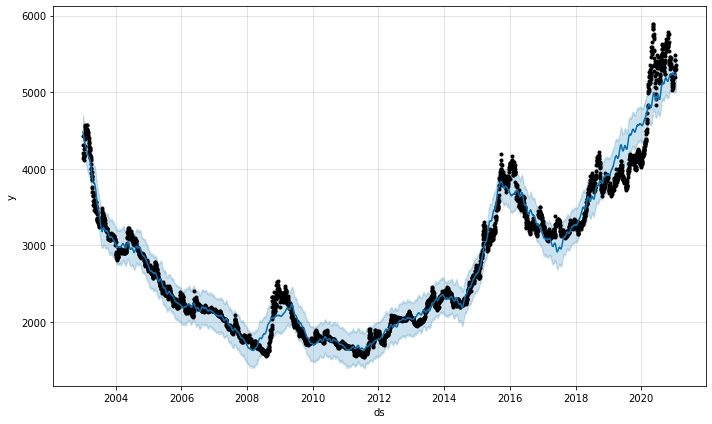

In [109]:
modelo_profeta_treinado.plot(resultado_profeta);

In [110]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=dados_dolar['Data'], y=dados_dolar['Fechamento'], name='Actual',))
fig.add_trace(go.Scatter(x=resultado_profeta['ds'], y=resultado_profeta['yhat'], name='Predicted',))
fig.show()

In [31]:
resultado_profeta

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2003-01-04,4023.220820,3652.033705,4254.576674,4023.220820,4023.220820,-78.814771,-78.814771,-78.814771,-93.142651,-93.142651,-93.142651,-1.173463,-1.173463,-1.173463,15.501343,15.501343,15.501343,0.0,0.0,0.0,3944.406049
1,2003-01-07,4017.063493,3603.842828,4245.905208,4017.063493,4017.063493,-89.416557,-89.416557,-89.416557,-93.142651,-93.142651,-93.142651,-7.223934,-7.223934,-7.223934,10.950028,10.950028,10.950028,0.0,0.0,0.0,3927.646937
2,2003-01-08,4015.011051,3605.038377,4257.774924,4015.011051,4015.011051,-74.724505,-74.724505,-74.724505,-93.142651,-93.142651,-93.142651,9.331982,9.331982,9.331982,9.086164,9.086164,9.086164,0.0,0.0,0.0,3940.286546
3,2003-01-09,4012.958609,3596.785172,4223.195527,4012.958609,4012.958609,-91.559621,-91.559621,-91.559621,-93.142651,-93.142651,-93.142651,-5.543836,-5.543836,-5.543836,7.126866,7.126866,7.126866,0.0,0.0,0.0,3921.398988
4,2003-01-10,4010.906167,3592.329798,4224.025639,4010.906167,4010.906167,-82.951546,-82.951546,-82.951546,-93.142651,-93.142651,-93.142651,5.067649,5.067649,5.067649,5.123456,5.123456,5.123456,0.0,0.0,0.0,3927.954621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459,2021-07-01,5644.549832,5251.964923,5869.595515,5644.549832,5644.549832,-89.957159,-89.957159,-89.957159,-93.142651,-93.142651,-93.142651,-5.543836,-5.543836,-5.543836,8.729329,8.729329,8.729329,0.0,0.0,0.0,5554.592673
4460,2021-08-01,5698.131729,5240.222332,5860.774538,5698.131729,5698.131729,-139.951897,-139.951897,-139.951897,-93.142651,-93.142651,-93.142651,2.779848,2.779848,2.779848,-49.589094,-49.589094,-49.589094,0.0,0.0,0.0,5558.179832
4461,2021-11-01,5857.148973,5444.376571,6063.647561,5857.148973,5857.148973,-114.319424,-114.319424,-114.319424,-93.142651,-93.142651,-93.142651,-3.238246,-3.238246,-3.238246,-17.938527,-17.938527,-17.938527,0.0,0.0,0.0,5742.829549
4462,2021-12-01,5909.002422,5497.486319,6141.809704,5909.002422,5909.002422,-93.857553,-93.857553,-93.857553,-93.142651,-93.142651,-93.142651,9.331982,9.331982,9.331982,-10.046884,-10.046884,-10.046884,0.0,0.0,0.0,5815.144869


In [146]:
dados_teste

,Casos,Mes,MM_3,MM_6,MM_3c,Ano,Previsao
Data,,,,,,,
2019-01-01,8392,1,7667.666667,8050.166667,7682.000000,2019,8216.642409
2019-02-01,7754,2,7682.000000,7853.500000,7931.333333,2019,7149.994268
2019-03-01,7648,3,7931.333333,7851.000000,7892.000000,2019,7970.019660
2019-04-01,8274,4,7892.000000,7779.833333,8101.666667,2019,8163.988397
2019-05-01,8383,5,8101.666667,7891.833333,8006.666667,2019,7785.686619
2019-06-01,7363,6,8006.666667,7969.000000,8042.666667,2019,7891.921128
2019-07-01,8382,7,8042.666667,7967.333333,7994.666667,2019,7928.508417
2019-08-01,8239,8,7994.666667,8048.166667,8254.666667,2019,8471.047794
2019-09-01,8143,9,8254.666667,8130.666667,8324.666667,2019,7865.801453


In [ ]:
dados_passengers

,Data,Passageiros,Mes,Ano
0,1949-01-01,112,1,1949
1,1949-02-01,118,2,1949
2,1949-03-01,132,3,1949
3,1949-04-01,129,4,1949
4,1949-05-01,121,5,1949
...,...,...,...,...
139,1960-08-01,606,8,1960
140,1960-09-01,508,9,1960
141,1960-10-01,461,10,1960
142,1960-11-01,390,11,1960


## Desafio 01: Transformar os dados em uma série temporal: ANO-MES

## Desafio 02: Converter a coluna data para o tipo datetime

## Desafio 03: Realizar os mesmos processos de transformação dos dados para a base de dados de Hanseníase

## Desafio 04: Deixar o gráfico da série temporal visualmente melhor

## Desafio 05: Analisar outras janelas para média móvel.

## Desafio 06: Realizar sua primeira previsão utilizando médias( toda a série, 3 últimos meses)

In [ ]:
dados_time_series.tail(1)

In [ ]:
media_total =  dados_time_series.tail(1) #dados_time_series.copy()
media_total = media_total.append({'Data': '2020-01-01', 'Casos': dados_time_series['Casos'].mean()}, ignore_index=True)
media_total['Data'] = pd.to_datetime(media_total['Data'])
media_total

In [ ]:
dados_time_series2 = dados_time_series.copy()
dados_time_series2['Casos_Ultimo_Mes'] = dados_time_series2['Casos'].shift()
dados_time_series2['Diff_Casos_Ultimo_Mes'] = dados_time_series2['Casos_Ultimo_Mes'].diff()
dados_time_series2 = dados_time_series2.dropna()
dados_time_series2.head()

In [ ]:
dados_time_series2.tail()

In [ ]:
def rmsle(ytrue, ypred):
    return np.sqrt(mean_squared_log_error(ytrue, ypred))

In [ ]:
#dados_time_series2.query('Data >= "2019-09-01"')['Mes']
dados_time_series2.query('Data >= "2019-08-01"')[dados_time_series2['Mes'] < month]

In [ ]:
mean_error = []
for month in range(9,12):
    train = dados_time_series2.query('Data >= "2019-08-01"')[dados_time_series2['Mes'] < month]
    val = dados_time_series2.query('Data >= "2019-08-01"')[dados_time_series2['Mes'] == month]
    
    p = val['Casos_Ultimo_Mes'].values
    
    error = rmsle(val['Casos'].values, p)
    print('Mes %d - Erro %.5f' % (month, error))
    mean_error.append(error)
print('Média Erro = %.5f' % np.mean(mean_error))

In [ ]:
train

In [ ]:
val

In [ ]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Data', y='Casos', data=dados_time_series, palette="tab10", linewidth=1.5)
plt.plot(media_total.Data, media_total.Casos, 'r--')

plt.title('Previsão do próximo mês com uso de médias móveis - Pela média total')
plt.xticks(rotation= 30)
plt.show()

In [ ]:
media = dados_time_series['Casos'].tail(3).mean()

media_ultimos_meses = dados_time_series.tail(1)
media_ultimos_meses = media_ultimos_meses.append({'Data': '2020-01-01', 'Casos': media}, ignore_index=True)
media_ultimos_meses['Data'] = pd.to_datetime(media_ultimos_meses['Data'])
media_ultimos_meses

In [ ]:
plt.figure(figsize=(15,5))

sns.lineplot(x='Data', y='Casos', data=dados_time_series, palette="tab10", linewidth=1.5)
plt.plot(media_ultimos_meses.Data, media_ultimos_meses.Casos, 'r--')

plt.title('Previsão do próximo mês com uso de médias móveis - Últimos 3 mêses')
plt.xticks(rotation= 30)
plt.show()

## Desafio 07: Transformar as datas em index e realizar os slices pelas datas

## Desafio 08: Formatar os gráficos de decomposição, colocar título e modificar os tamanhos. Realizar a decomposição de outras séries temporais.

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

decomposicao =  seasonal_decompose(dados_passengers['#Passengers'])
fig = decomposicao.plot()
fig.axes[0].set_title('Decomposição da série de passageiros.')

plt.show()

## Desafio 09: Realizar uma análise de autocorrelação e autocorrelação parcial dos dados de COVID-19

## Desafio 10: Na tupla de retorno do forecast, estudar o que são os elementos 1 e 2.

## Desafio 11: Utilizar o ARIMA para a base de dados passageiros e modificar os parâmetros order.

In [ ]:
dados_passengers

,Data,Passageiros,Mes,Ano
0,1949-01-01,112,1,1949
1,1949-02-01,118,2,1949
2,1949-03-01,132,3,1949
3,1949-04-01,129,4,1949
4,1949-05-01,121,5,1949
...,...,...,...,...
139,1960-08-01,606,8,1960
140,1960-09-01,508,9,1960
141,1960-10-01,461,10,1960
142,1960-11-01,390,11,1960


<AxesSubplot:xlabel='Data', ylabel='Passageiros'>

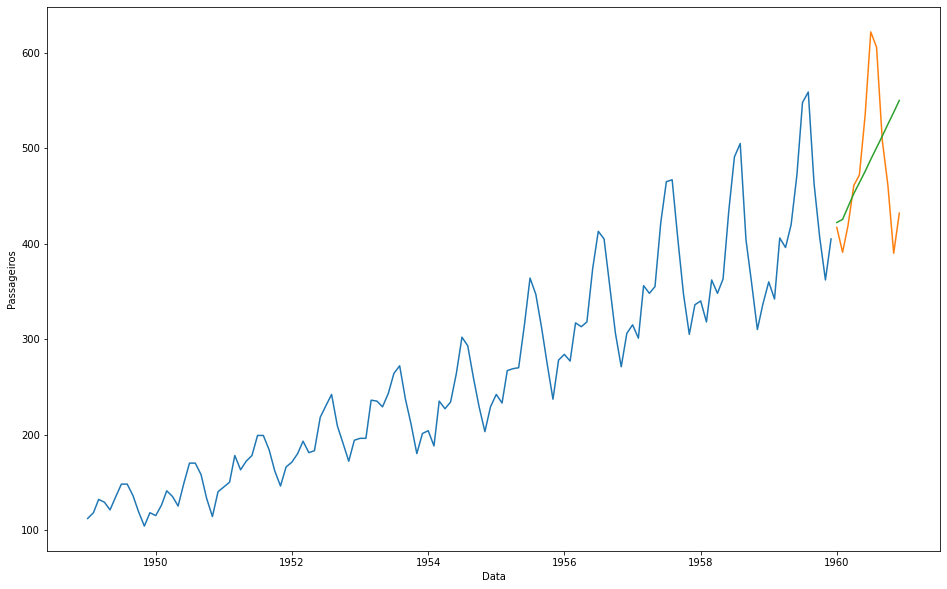

In [ ]:
dados_treino = dados_passengers.query("Ano != 1960")
dados_teste = dados_passengers.query('Ano == 1960')

modelo_arima = ARIMA(dados_treino['Passageiros'].values.astype('float32'), order=[2,2,0])
modelo_arima_treinado = modelo_arima.fit()
previsao = modelo_arima_treinado.forecast(12)[0]

dados_teste['Previsao'] = previsao
plt.figure(figsize=(16,10))
sns.lineplot(x='Data', y='Passageiros', data= dados_treino)
sns.lineplot(x='Data', y='Passageiros', data= dados_teste)
sns.lineplot(x='Data', y='Previsao', data= dados_teste)


## Desafio 12: Visualizar as séries temporias diferenciadas (Dicas dii pandas)

## Desafio 13: Variar os parâmetros max_p(d,q)

## Desafio 14: Testar vários parâmetros para os dados de passageiros.

## Desafio 15: Plotar os valores reais e os valores previstos pelo Prophet. Fazer a mesma análise para os dados de tuberculose.

In [ ]:
array_diff([1,2,2], [1]), [2],

In [38]:
def array_diff(a,b):
  return [x for x in a if x not in b]

In [40]:
array_diff([1,2,2], [1])

[2, 2]

In [36]:
def get_sum(a,b):
 return sum(range(min(a, b), max(a, b) + 1))

In [21]:
def validate_pin(pin):
    return len(pin) in (4, 6) and pin.isdigit()



In [23]:
validate_pin('2533')


True

In [20]:
teste = '1w474'
for i in range(0,len(teste)):
  print(teste[i])
  if teste[i].isdigit():
    print('ok')
  else:
    print('false')

1
ok
w
false
4
ok
7
ok
4
ok


In [16]:
type('1')


str

In [41]:
get_sum(-1, 3)#-1 + 0 + 1 + 2 = 2

5

In [42]:
!pip install codewars_test

ERROR: Could not find a version that satisfies the requirement codewars_test (from versions: none)
ERROR: No matching distribution found for codewars_test


In [1]:
!pip install -q datasets

     |████████████████████████████████| 163kB 6.3MB/s 
     |████████████████████████████████| 245kB 8.7MB/s 
     |████████████████████████████████| 17.7MB 1.2MB/s 


In [2]:
from datasets import load_dataset
dataset = load_dataset('xsum')
for ex in dataset["train"]:
    if "Ithaca" in ex["summary"]:
        print(ex)

Using custom data configuration default


Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/f9abaabb5e2b2a1e765c25417264722d31877b34ec34b437c53242f6e5c30d6d. Subsequent calls will reuse this data.
{'document': "Delek won sufficient Ithaca shareholder support to see off those who said the valuation was too low.\nThe firm had secured 76% of the shareholding by the offer deadline on Thursday.\nIthaca Energy is headquartered in Aberdeen while being listed on the Toronto stock exchange.\nThe deal adds to Delek's stake in Faroe Petroleum, purchased in late 2016.\nHaving found two large gas fields in the eastern Mediterranean, Delek is now investing in assets elsewhere to balance its portfolio with oil and gas fields that are already producing.\nIthaca is also part of a consortium developing an onshore oil field in southern England.\nIt is the operator of the Greater Stella field in the central North Sea, which began production at a low flow-rate in February, and is expected to ramp up from 